# Data Preparation

In [19]:
import pandas as pd
import numpy as np


loan_dev = pd.read_csv('data/loan_dev.csv')
client = pd.read_csv('data/client.csv')
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')


{'whiskers': [<matplotlib.lines.Line2D at 0x13f967d90>,
 'caps': [<matplotlib.lines.Line2D at 0x13f990370>,
 'boxes': [<matplotlib.lines.Line2D at 0x13f967ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x13f990910>],
 'fliers': [<matplotlib.lines.Line2D at 0x13f990be0>],
 'means': []}

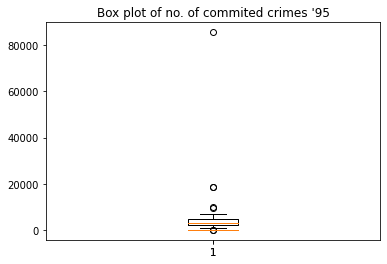

In [20]:

import matplotlib.pyplot as plt

district_clean = district.loc[district["no. of commited crimes '95"] != '?']
# district_clean

plt.title("Box plot of unemploymant rate '95")
plt.boxplot(district_clean["unemploymant rate '95"].astype('float'))


plt.title("Box plot of no. of commited crimes '95")
plt.boxplot(district_clean["no. of commited crimes '95"].astype('int'))



In [22]:

median_unemploymant = district_clean["unemploymant rate '95"].astype(float).median()
median_commited_crimes = district_clean["no. of commited crimes '95"].astype(int).median()


district.loc[district["no. of commited crimes '95"] == '?', "no. of commited crimes '95"] = median_commited_crimes
district.loc[district["unemploymant rate '95"] == '?', "unemploymant rate '95"] = median_unemploymant

# Convert Object Type to Numeric Type
district["unemploymant rate '95"] = pd.to_numeric(district["unemploymant rate '95"])
district["no. of commited crimes '95"] = pd.to_numeric(district["no. of commited crimes '95"])

# Growths
district['criminality_growth'] = (district["no. of commited crimes '96"] - district["no. of commited crimes '95"]) / district["no. of inhabitants"]
# district['unemploymant_growth'] = district["unemploymant rate '96"] - district["unemploymant rate '95"]

# district.drop(columns=['name', 'no. of enterpreneurs per 1000 inhabitants', 'no. of inhabitants',
# "unemploymant rate '96", "no. of commited crimes '96",
# "unemploymant rate '95", "no. of commited crimes '95"], inplace=True)

KeyError: "no. of commited crimes '96"

By analysing the box plots, we found out that the data values for "no. of commited crimes '95" and "unemploymant rate '95" are not symmetrical and there are outliers, therefore is would be best to use median instead of mean to replace the cells with '?'

In [2]:
# Parse client birth number into age and gender
'''
from datetime import datetime

def cal_age(birthday):
    today = datetime.today()
    years = today.year - birthday.year
    if today.month < birthday.month or (today.month == birthday.month and today.day < birthday.day):
        years -= 1
    return years

def parse_birthNumber(birthNumber):
    year = int('19' + str(birthNumber)[0:2]) if int(str(birthNumber)[0:2]) > 22 else int('20' + str(birthNumber)[0:2]) # Limits birth year between 1923 - 2022 (Change this if needed)
    month = int(str(birthNumber)[2:4])
    day = int(str(birthNumber)[-2:])
    gender = ''
    if month > 12:
        month -= 50
        gender ='Female'
    else: 
        gender = 'Male'

    return cal_age(datetime(year, month, day)), gender

genders = []
ages = []

for birthNumber in client['birth_number']:
    age, gender = parse_birthNumber(birthNumber)
    genders.append(gender)
    ages.append(age)

client['age'] = ages
client['gender'] = genders

client = client.drop('birth_number', axis=1)
'''

"\nfrom datetime import datetime\n\ndef cal_age(birthday):\n    today = datetime.today()\n    years = today.year - birthday.year\n    if today.month < birthday.month or (today.month == birthday.month and today.day < birthday.day):\n        years -= 1\n    return years\n\ndef parse_birthNumber(birthNumber):\n    year = int('19' + str(birthNumber)[0:2]) if int(str(birthNumber)[0:2]) > 22 else int('20' + str(birthNumber)[0:2]) # Limits birth year between 1923 - 2022 (Change this if needed)\n    month = int(str(birthNumber)[2:4])\n    day = int(str(birthNumber)[-2:])\n    gender = ''\n    if month > 12:\n        month -= 50\n        gender ='Female'\n    else: \n        gender = 'Male'\n\n    return cal_age(datetime(year, month, day)), gender\n\ngenders = []\nages = []\n\nfor birthNumber in client['birth_number']:\n    age, gender = parse_birthNumber(birthNumber)\n    genders.append(gender)\n    ages.append(age)\n\nclient['age'] = ages\nclient['gender'] = genders\n\nclient = client.drop('b

### Extract gender and normalize dates
Since the birth date of each client is represented as YYMMDD when 'Male' or YY(MM+50)DD when 'Female' the gender was extracted as a new feature and the Female client's birth date modified to YYMMDD, the same as Male clients.
Female = False
Male = True

In [3]:
from datetime import datetime, timedelta

def extract_gender(date):
    month = int(str(date)[2:4])
    gender = ''
    if month > 12:
        month -= 50
        gender =False
    else: 
        gender = True
    new_date = str(date)[:2] + str(month).zfill(2) + str(date)[4:]
    return (new_date, gender)

In [4]:
genders = []
dates = []

for birth_number in client['birth_number']:
    (new_date, gender) = extract_gender(birth_number)
    dates.append(new_date)
    genders.append(gender)

client['birth_number'] = dates
client['gender'] = genders

### Remove disponent clients and add to the account's owner entry
Without this chenage more than one client were associated to a single account_id. This was a problem when merging Dispositions Loans tables since this would lead to several entries with the same loan_id and target classes replicated.

In [5]:
disp_owners = disposition.query("type == 'OWNER'")
disp_disponent = disposition.query("type == 'DISPONENT'")

has_disponent = []
for id in disp_owners['account_id']:
    if id in disp_disponent['account_id']:
        has_disponent.append(True)
    else:
        has_disponent.append(False)

disp_owners['has_disponent'] = has_disponent
disp_owners = disp_owners.drop('type', axis=1)
print(disp_owners)

      disp_id  client_id  account_id  has_disponent
0           1          1           1          False
1           2          2           2           True
3           4          4           3          False
5           6          6           4           True
6           7          7           5          False
...       ...        ...         ...            ...
5363    13623      13931       11333          False
5364    13647      13955       11349          False
5366    13660      13968       11359          False
5367    13663      13971       11362          False
5368    13690      13998       11382          False

[4500 rows x 4 columns]


/tmp/ipykernel_12762/1478729136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disp_owners['has_disponent'] = has_disponent


In [6]:
data = pd.merge(client, disp_owners, left_on="client_id", right_on="client_id", how='inner')
data = pd.merge(loan_dev, data, left_on="account_id", right_on="account_id", how='inner')
data

,loan_id,account_id,date,amount,duration,payments,status,client_id,birth_number,district_id,gender,disp_id,has_disponent
0,5314,1787,930705,96396,12,8033,-1,2166,470722,30,False,2166,False
1,5316,1801,930711,165960,36,4610,1,2181,680722,46,True,2181,False
2,6863,9188,930728,127080,60,2118,1,11314,360602,45,True,11006,False
3,5325,1843,930803,105804,36,2939,1,2235,400420,14,False,2235,False
4,7240,11013,930906,274740,60,4579,1,13539,780907,63,True,13231,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,48,3242,1,11121,710410,72,False,10813,False
324,5625,3189,961215,222180,60,3703,-1,3855,390320,29,True,3855,False
325,6805,8972,961221,45024,48,938,1,11050,570504,70,False,10742,False
326,7233,10963,961225,115812,36,3217,1,13480,530601,16,True,13172,False


### Merge the date of the loan and the birth date of the client resulting on the age of the client at the loan time

In [7]:
def get_datetime(date):
    year = int(str(date)[0:2]) + 1900
    month = int(str(date)[2:4])
    day = int(str(date)[4:])
    return datetime(year, month, day)

def calc_age(birth_date, other_date):
    diff:timedelta = get_datetime(other_date) - get_datetime(birth_date)
    return round(diff.days / 365.25)


In [8]:
data['age_on_loan_request'] = data.apply(lambda x: calc_age(x['birth_number'], x['date']), axis=1)
data.drop('date', inplace=True, axis=1)
data.drop('birth_number', inplace=True, axis=1)
data

,loan_id,account_id,amount,duration,payments,status,client_id,district_id,gender,disp_id,has_disponent,age_on_loan_request
0,5314,1787,96396,12,8033,-1,2166,30,False,2166,False,46
1,5316,1801,165960,36,4610,1,2181,46,True,2181,False,25
2,6863,9188,127080,60,2118,1,11314,45,True,11006,False,57
3,5325,1843,105804,36,2939,1,2235,14,False,2235,False,53
4,7240,11013,274740,60,4579,1,13539,63,True,13231,False,15
...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,11121,72,False,10813,False,26
324,5625,3189,222180,60,3703,-1,3855,29,True,3855,False,58
325,6805,8972,45024,48,938,1,11050,70,False,10742,False,40
326,7233,10963,115812,36,3217,1,13480,16,True,13172,False,44


In [9]:

data.to_csv('data_processed/data.csv', index=False)